In [1]:
import os
project_path = "D:/workspace/Bus Project"
os.chdir(project_path)

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
from multiprocessing import Pool
import multiprocessing
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
from functools import partial

import bus.analyzer as anz
import stay

In [4]:
def parallelize_dataframe(func, df, core = 4):
    df_split = np.array_split(df, core)
    pool = Pool(core)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def parallelize_list(func, _list, core = 4):
    df_split = np.array_split(_list, core)
    pool = Pool(core)
    temp_result = pool.map(func, df_split)
    return temp_result
    result = []
    for v in temp_result:
        result.extend(v)
    pool.close()
    pool.join()
    return result

In [5]:
# 데이터 기간 설정
start_date = datetime.datetime(2019, 6, 1)
end_date = datetime.datetime(2019, 6, 10)

# 로딩할 파일 명 리스트 생성
input_path_list = anz.make_input_path(start_date, end_date)

station_usage_df = parallelize_dataframe(anz.load_total_usage_data, input_path_list, core = 8)

# 데이터 로드
user_df = anz.load_user_df()
station_df = anz.load_station_df()
cluster_df = anz.load_cluster_df()
cluster_station_df = anz.load_cluster_station_df()

# 정류장 간 이동 데이터 -> 군집간 이동 데이터
cluster_usage_df = stay.create_cluster_usage_df(station_usage_df, cluster_station_df)

In [6]:
tourist_cluster_usage_df = stay.get_tourist_usage_df(cluster_usage_df, user_df)
tourist_stay_time_df = stay.get_stay_time_df(tourist_cluster_usage_df)
stay_time_count_df = stay.analyze_stay_time_count(tourist_stay_time_df)

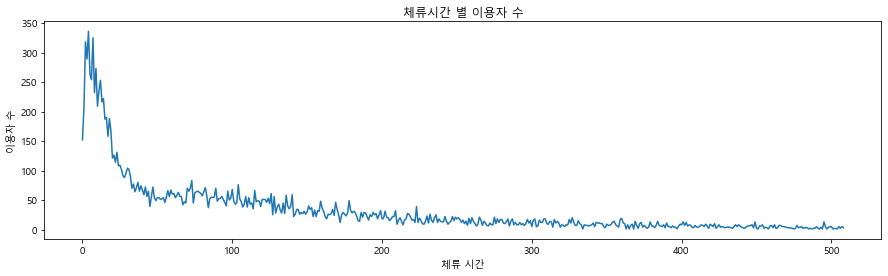

In [10]:
x = stay_time_count_df['stay_time'].head(500)
y = stay_time_count_df['num'].head(500)
stay.draw_stay_time_count(x, y)